### Training

In [9]:
# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway
import ezomero
# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas as pd
import warnings
from tifffile import imwrite

#micro-sam related imports
from micro_sam.sam_annotator import annotator_2d

In [13]:
output_folder = os.path.normcase(tempfile.mkdtemp())
print('Output Directory: ', output_folder)

Output Directory:  c:\users\mwpaul\appdata\local\temp\tmpigbue54a


In [14]:
### Setup connection with OMERO
conn = BlitzGateway(host='localhost', username='root', passwd='omero', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)


### Get info from the dataset
datatype = "dataset" # "plate", "dataset", "image"
data_id =  	652 
nucl_channel = 0

#validate that data_id matches datatype
if datatype == "plate":
    plate = conn.getObject("Plate", data_id)
    print('Plate Name: ', plate.getName())
elif datatype == "dataset":
    dataset = conn.getObject("Dataset", data_id)
    print('Dataset Name: ', dataset.getName())
elif datatype == "image":
    image = conn.getObject("Image", data_id)
    print('Image Name: ', image.getName())

True
Dataset Name:  metadat


In [17]:
from tifffile import imsave

z_slice: int = 5
channel: int = 0
timepoint: int = 0
#download table from omero, use it to collect training data
train_images = []
validate_images = []
file_ann_ids = ezomero.get_file_annotation_ids(conn, 'Dataset', data_id)
table = ezomero.get_table(conn, file_ann_ids[0]) #TODO: find the correct folder if there are multiple

#prepare training data
train_images = table[table['train'] == True]
print(train_images)
val_images = table[table['validate'] == True]
print(output_folder)
os.makedirs(os.path.join(output_folder, "tmp"), exist_ok=True)
training_input_dir = os.path.join(output_folder, "training_input")
os.makedirs(training_input_dir, exist_ok=True)
training_label_dir = os.path.join(output_folder, "training_label")
os.makedirs(training_label_dir, exist_ok=True)

for n in range(len(train_images)):
    image = conn.getObject('Image', int(train_images.iloc[n]['image_id']))
    pixels = image.getPrimaryPixels()
    img = pixels.getPlane(z_slice, channel, timepoint) #(z, c, t) 
    #save image to output folder
    # Normalize 16-bit to 8-bit using 0 as minimum
    img_8bit = ((img) * (255.0 / img.max())).astype(np.uint8)

    # Save as 8-bit tiff as required for micro-sam training
    imwrite(os.path.join(output_folder, "training_input", f"input_0000{n}.tif"), img_8bit)
    
    file_path = ezomero.get_file_annotation(conn, int(train_images.iloc[n]['label_id']), os.path.join(output_folder, "tmp"))
    os.rename(file_path, os.path.join(output_folder, "training_label", f"label_0000{n}.tif"))

val_input_dir = os.path.join(output_folder, "val_input")
os.makedirs(val_input_dir, exist_ok=True)
val_label_dir = os.path.join(output_folder, "val_label")
os.makedirs(val_label_dir, exist_ok=True) 

for n in range(len(val_images)):
    image = conn.getObject('Image', int(val_images.iloc[n]['image_id']))
    pixels = image.getPrimaryPixels()
    img = pixels.getPlane(z_slice, channel, timepoint) #(z, c, t) 
    # Normalize 16-bit to 8-bit using 0 as minimum
    img_8bit = ((img) * (255.0 / img.max())).astype(np.uint8)
    #save image to output folder
    imsave(os.path.join(output_folder, "val_input", f"input_0000{n}.tif"), img_8bit)
    file_path = ezomero.get_file_annotation(conn, int(val_images.iloc[n]['label_id']), os.path.join(output_folder, "tmp"))
    os.rename(file_path, os.path.join(output_folder, "val_label", f"label_0000{n}.tif"))





   image_id  channel  timepoint  embed_id  label_id  roi_id  \
0      2221        3          0      2392      2393     557   
2      2223        3          0      2396      2397     559   
4      2225        3          0      2400      2401     561   
6      2227        3          0      2404      2405     563   

                                          image_name sam_model  train  \
0  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   
2  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   
4  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   
6  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   

   validate  
0     False  
2     False  
4     False  
6     False  
c:\users\mwpaul\appdata\local\temp\tmpigbue54a


C:\Users\mwpaul\AppData\Local\Temp\ipykernel_47272\3104855966.py:49: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(os.path.join(output_folder, "val_input", f"input_0000{n}.tif"), img_8bit)


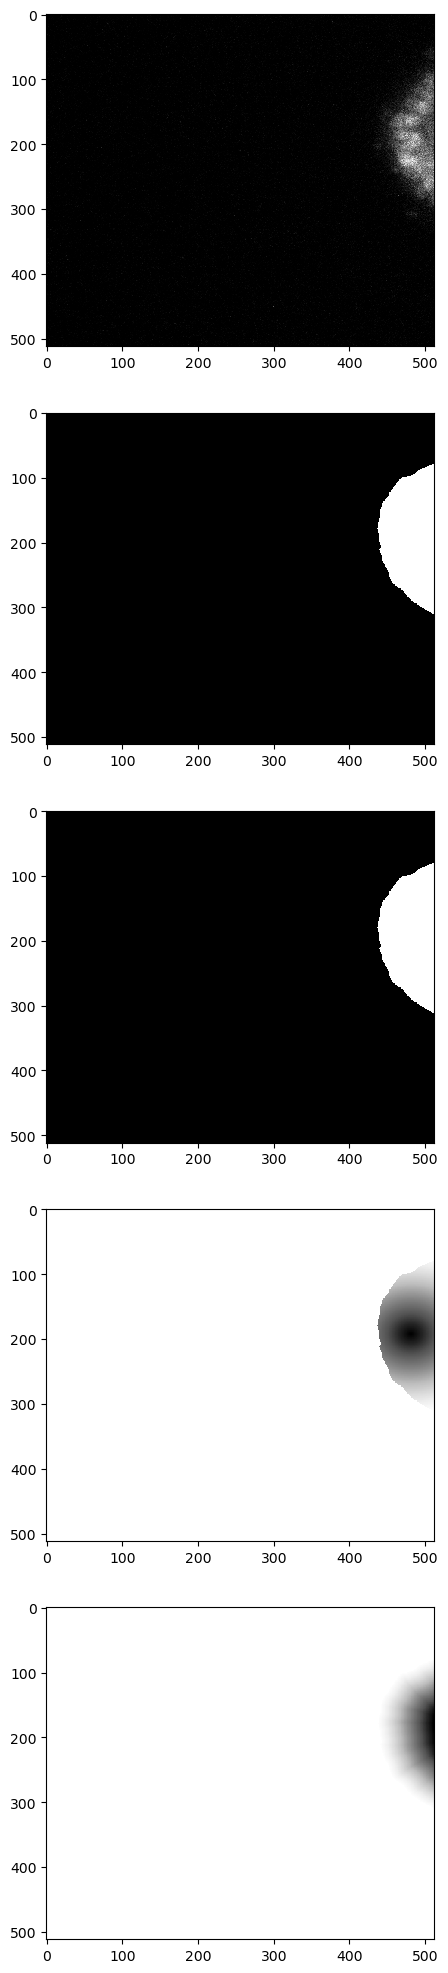

In [18]:
import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler
from torch_em.util.util import get_random_colors

import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

batch_size = 1  # pipphe training batch size
patch_shape = (1, 512, 512)  # the size of patches for training
# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
# NOTE 1: It's important to have densely annotated-labels while training the additional convolutional decoder.
# NOTE 2: In case you do not have labeled images, we recommend using `micro-sam` annotator tools to annotate as many objects as possible per image for best performance.
train_instance_segmentation = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# There are cases where our inputs are large and the labeled objects are not evenly distributed across the image.
# For this we use samplers, which ensure that valid inputs are chosen subjected to the paired labels.
# The sampler chosen below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
sampler = MinInstanceSampler(min_size=25)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=training_input_dir,
    raw_key=raw_key,
    label_paths=training_label_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    #rois=train_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=val_input_dir,
    raw_key=raw_key,
    label_paths=val_label_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    #rois=val_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)
check_loader(train_loader, 1, plt=True)

### Running the training

In [19]:
n_objects_per_batch = 2  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 20  # how long we train (in epochs)
print('running on: ', device)
# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_l"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam"

sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(output_folder, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

running on:  cuda


Verifying labels in 'val' dataloader: 100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


Start fitting for 2000 iterations /  20 epochs
with 100 iterations per epoch
Training with mixed precision


Epoch 17: average [s/it]: 1.243986, current metric: 0.259220, best metric: 0.154597:  90%|█████████ | 1800/2000 [49:05<05:27,  1.64s/it]  

Stopping training because there has been no improvement for 10 epochs
Finished training after 17 epochs / 1800 iterations.
The best epoch is number 6.
Training took 2954.2020370960236 seconds (= 00:49:14 hours)


### zip and upload to OMERO

In [20]:
#zip model folder and upload to omero, attach to dataset
def zip_directory(folder_path, zip_file):
    for folder_name, subfolders, filenames in os.walk(folder_path):
        for filename in filenames:
            # Create complete filepath of file in directory
            file_path = os.path.join(folder_name, filename)
            # Add file to zip
            zip_file.write(file_path)

zip_file = os.path.join(output_folder, "models.zip")
ns = 'model.microsam.vit_l'
zip_directory(os.path.join(output_folder, "models"),zip_file)


ezomero.post_file_annotation(conn, zip_file, ns, "Dataset", data_id)

AttributeError: 'str' object has no attribute 'write'